<h1 style="color: #4169E1; text-align: center;">
    The Spatial Dynamics of the Sharing Economy: A Computational Analysis of Austin, Texas
</h1>

## 1. Introduction
Short-term rentals (STRs) facilitated by platforms like Airbnb are reshaping urban housing by embedding tourism within residential neighborhoods. Austin, Texas - characterized by rapid Sun Belt growth and enduring racial segregation - offers a compelling case to study these dynamics. This essay integrates digital platform data from Inside Airbnb with the American Community Survey (2018-2022) to examine how STRs intersect with demographic patterns, gentrification pressures, and neighborhood inequality.

## 2. Data Sources and "New" Spatial Data:
Primary data were sourced from Inside Airbnb (2025), providing crowdsourced STR listings. To reduce skew, the top 1% of nightly prices (>$2,000) were excluded. The US Census Bureau (2022) provided demographic indicators via the ACS. All spatial data were reprojected to EPSG:32139 for accurate density analysis. Listing density (listings/km²) was calculated with missing counts imputed as zero, and prices were log-transformed to enable effective classification of skewed distributions.

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import requests
import numpy as np
from libpysal.weights import Queen
from esda import Moran_Local
from splot.esda import lisa_cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
# Setting CRS to Texas Central (Meters)
target_crs = "EPSG:32139" 

# Styling for professional mapping
def add_north_arrow(ax, xpos=0.95, ypos=0.95):
    ax.text(xpos, ypos, 'N', transform=ax.transAxes, ha='center', va='bottom', fontsize=14, fontweight='bold')
    ax.annotate('', xy=(xpos, ypos - 0.01), xytext=(xpos, ypos - 0.1),
                arrowprops=dict(facecolor='black', width=0, headwidth=12, headlength=12), xycoords=ax.transAxes)

def add_scale_bar(ax, length_km=5, location=(0.25, 0.03)):
    x_min, x_max = ax.get_xlim()
    width_meters = x_max - x_min
    if width_meters <= 0: return
    bar_width = (length_km * 1000) / width_meters
    ax.plot([location[0], location[0] + bar_width], [location[1], location[1]], 
            transform=ax.transAxes, color='black', linewidth=2)
    ax.text(location[0] + bar_width/2, location[1] + 0.02, f"{length_km} km", 
            transform=ax.transAxes, ha='center', va='bottom', fontsize=10, fontweight='bold')

In [4]:
# Loading Data
airbnb_df = pd.read_csv("C:/Users/flavi/Downloads/envs563/Assignment 2/data/listings.csv/airbnb.csv")
gdf = gpd.read_file('data/austin.shp').rename(columns={'ZCTA5CE20': 'GEOID'})

In [5]:
# Exploration & Cleaning
# Cleaning Price Column
airbnb_df['price'] = airbnb_df['price'].astype(str).str.replace(r'[$,]', '', regex=True).astype(float)

In [6]:
# Removing invalid prices and Outliers (Top 1%)
upper_limit = airbnb_df['price'].quantile(0.99)
airbnb_df = airbnb_df[(airbnb_df['price'] > 0) & (airbnb_df['price'] < upper_limit)]

In [7]:
# Converting to GeoDataFrame and Projecting
airbnb_gdf = gpd.GeoDataFrame(
    airbnb_df, geometry=gpd.points_from_xy(airbnb_df.longitude, airbnb_df.latitude), crs="EPSG:4326"
).to_crs(target_crs)
austin_zctas = gdf[gdf['GEOID'].str.startswith('787')].to_crs(target_crs)

In [8]:
# Joining Points to Polygons
joined = gpd.sjoin(airbnb_gdf, austin_zctas, how="inner", predicate="within")
airbnb_stats = joined.groupby('GEOID').agg(
    listing_count=('price', 'count'), avg_price=('price', 'mean')
).reset_index()

In [9]:
# Loading Census API data
austin_zip_list = austin_zctas['GEOID'].unique().tolist()
zips_formatted = ",".join(austin_zip_list)
census_url = "https://api.census.gov/data/2022/acs/acs5"
params = {
    "get": "NAME,B01003_001E,B19013_001E,B01002_001E", 
    "for": f"zip code tabulation area:{zips_formatted}",
}

In [10]:
try:
    response = requests.get(census_url, params=params)
    response.raise_for_status()
    data = response.json()
    census_data = pd.DataFrame(data[1:], columns=data[0]) 
    census_data = census_data.rename(columns={'B01003_001E': 'population', 'B19013_001E': 'median_income', 
                                              'B01002_001E': 'median_age', 'zip code tabulation area': 'GEOID'})
    for col in ['population', 'median_income', 'median_age']:
        census_data[col] = pd.to_numeric(census_data[col], errors='coerce')
except Exception as e:
    print(f"Census API failed: {e}. Check key/connection.")
    # To prevent API crash
    census_data = pd.DataFrame({'GEOID': austin_zip_list})


In [11]:
# Ensuring -ve values to be treated as NaN
census_data.loc[census_data['median_income'] < 0, 'median_income'] = np.nan

In [12]:
# Merge airbnb with census data
final_gdf = austin_zctas.merge(airbnb_stats, on='GEOID', how='left')
final_gdf = final_gdf.merge(census_data, on='GEOID', how='left')

In [13]:
# Calculating Density
final_gdf['listing_count'] = final_gdf['listing_count'].fillna(0)
final_gdf['area_sqkm'] = final_gdf.geometry.area / 10**6
final_gdf['listing_density'] = final_gdf['listing_count'] / final_gdf['area_sqkm']
airbnb_gdf['log_price'] = np.log(airbnb_gdf['price'] + 1)

## 3. Mapping and Visualization Analysis

**3.1 The Commercial Geography of Austin**

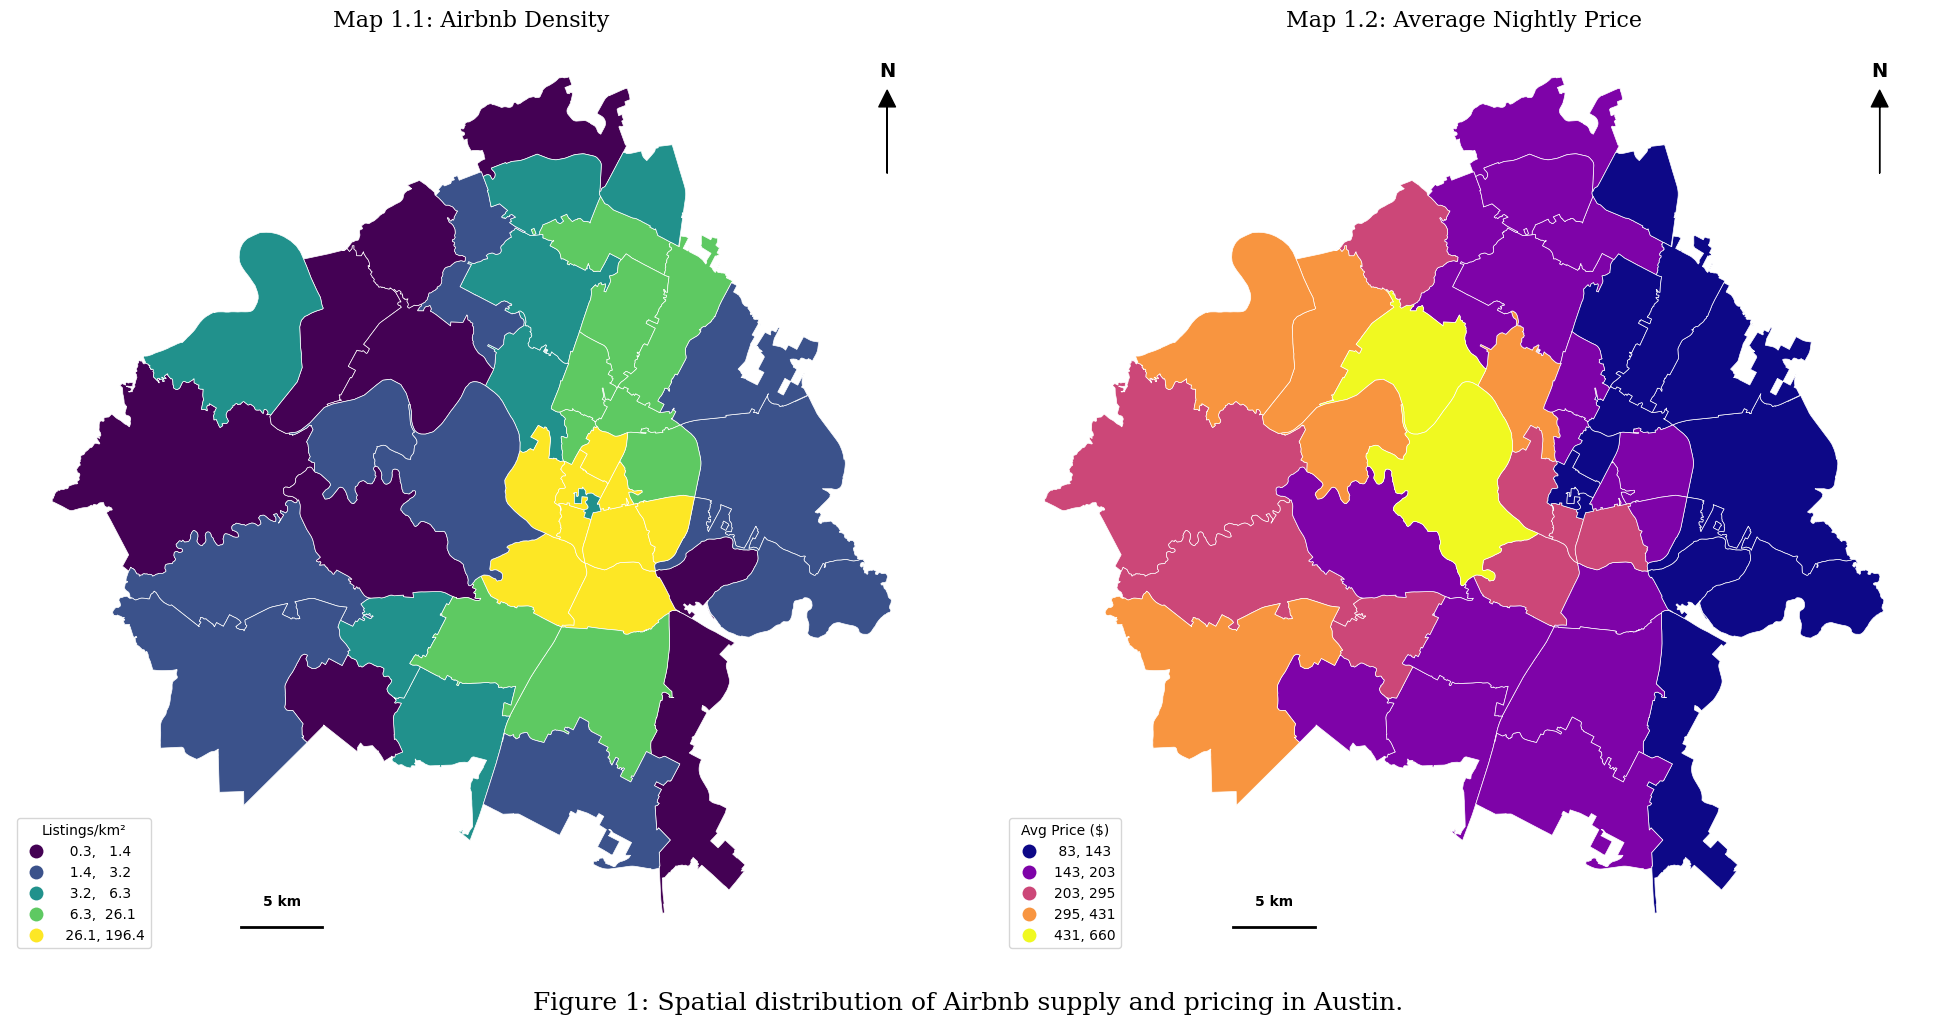

In [14]:
# FIigure 1: Airbnb Supply & Demand
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Map 1.1: Airbnb Density
# Quantiles (k=5) to show the "Top 20%" vs "Bottom 20%" clearly.
final_gdf.plot(column='listing_density', scheme='Quantiles', k=5, 
               cmap='viridis', edgecolor='white', linewidth=0.5, legend=True, ax=ax1,
               legend_kwds={'loc': 'lower left', 
                            'title': 'Listings/km²',
                            'fmt': '{:.1f}'}) # Rounds to 1 decimal point
ax1.set_title("Map 1.1: Airbnb Density", fontsize=16, fontfamily='serif')
add_north_arrow(ax1)
add_scale_bar(ax1)
ax1.set_axis_off()

# Map 1.2: Average Nightly Price
# Natural Breaks (Jenks) to isolate real price clusters
final_gdf.dropna(subset=['avg_price']).plot(
               column='avg_price', scheme='NaturalBreaks', k=5, 
               cmap='plasma', edgecolor='white', linewidth=0.5, legend=True, ax=ax2,
               legend_kwds={'loc': 'lower left', 
                            'fmt': '{:.0f}', # Rounds to whole number
                            'title': 'Avg Price ($)'})
ax2.set_title("Map 1.2: Average Nightly Price", fontsize=16, fontfamily='serif')
add_north_arrow(ax2)
add_scale_bar(ax2)
ax2.set_axis_off()

fig1.text(0.5, 0.01, "Figure 1: Spatial distribution of Airbnb supply and pricing in Austin.", 
          ha='center', fontfamily='serif', fontsize=18)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('output/Figure 1.jpeg', dpi=300)
plt.show()


Figure 1 maps the spatial divergence of Airbnb supply and value. Figure 1: Map 1.1 applies a Quantile classification (k=5) to normalize the highly skewed density distribution (Brewer, 2016), highlighting a stark core-periphery structure. The top 20% of tracts—visualized in bright yellow—exceed 26.1 listings/km² within the urban core and University corridor, while the peripheral residential belts (dark purple) remain largely inactive (< 1.4 listings/km²).
Conversely, Figure 1: Map 1.2 utilizes Natural Breaks (Jenks) optimization to maximize between-class variance, isolating distinct price tiers. High-value outliers are spatially decoupled from high-density zones; the most expensive tier (yellow, 431 - 660/night) clusters along the amenity - rich western lakeshore, distinct from the lower - cost eastern crescent (darkblue color, 83–143). This suggests the market is bifurcated between volume-driven central hubs and exclusive, value-driven western enclaves.

**3.2 The Socio-Economic Landscape**

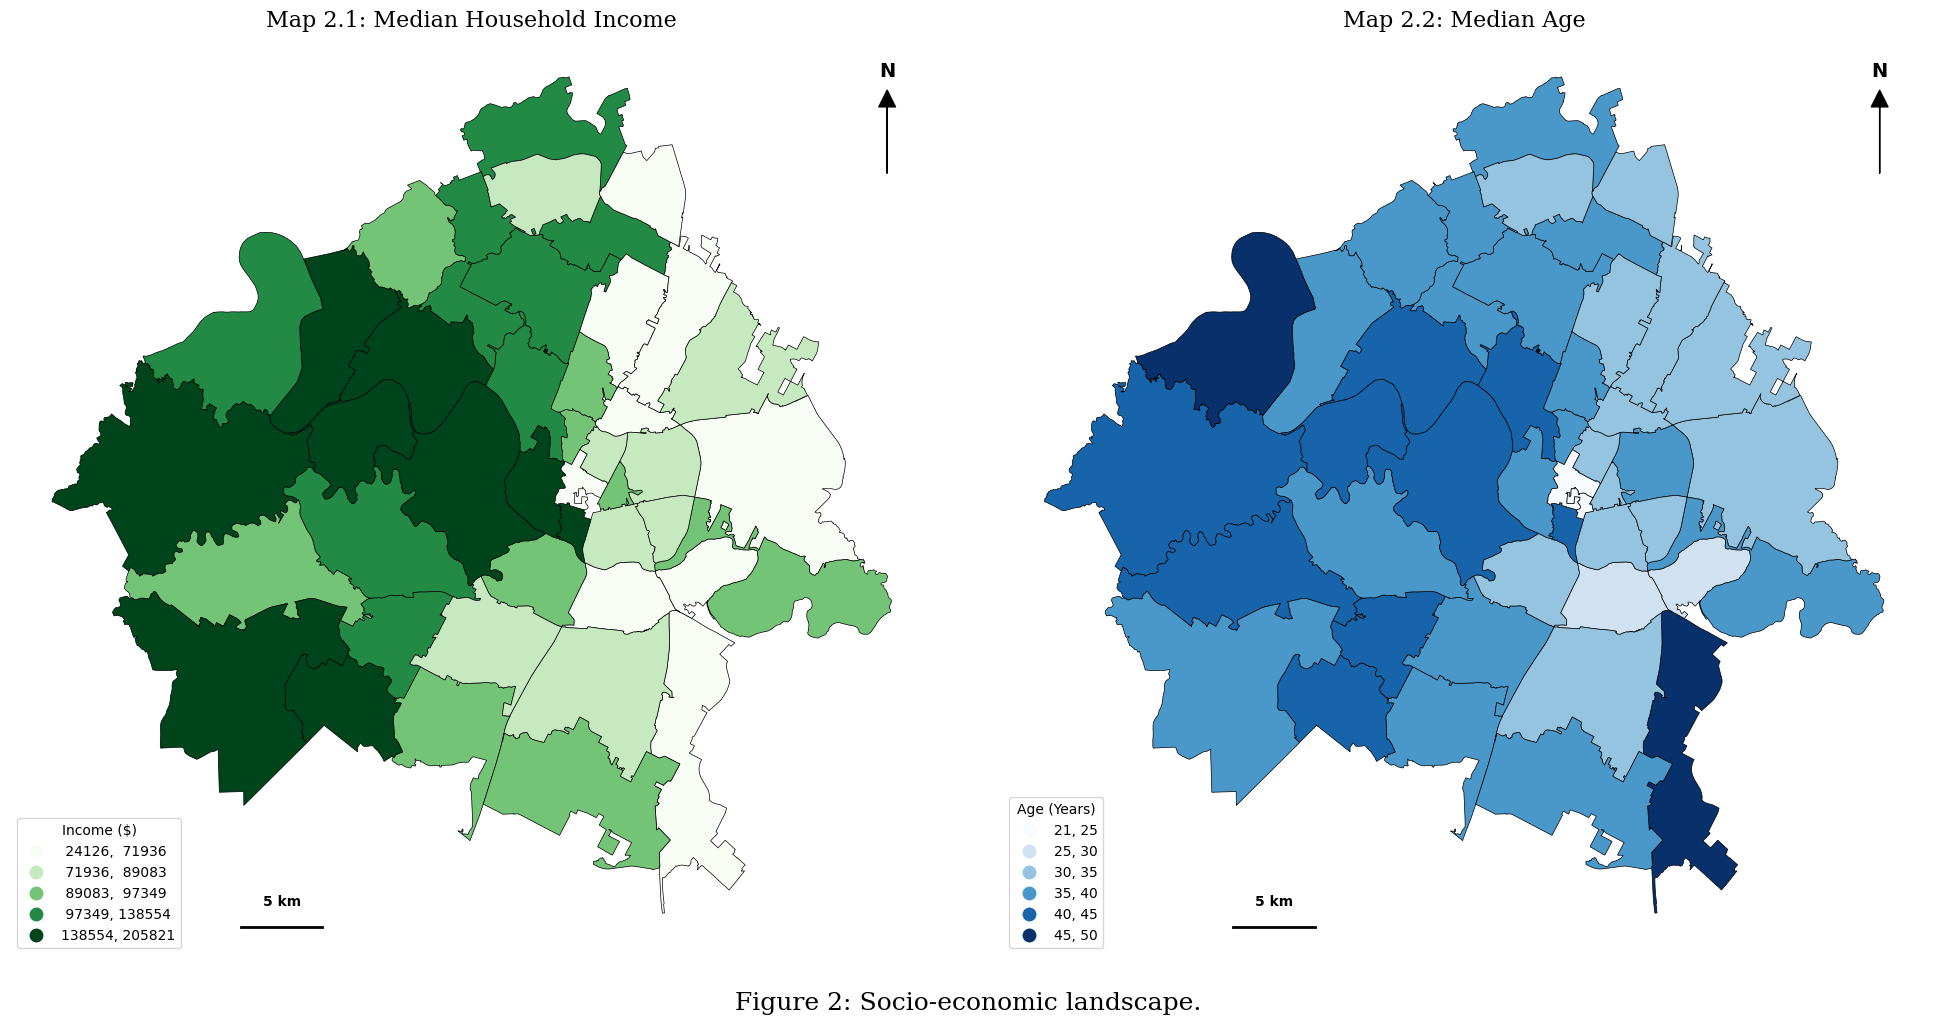

In [15]:
# Figure 2: Socio-Economic Context
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(20, 10))

# Map 2.1: Median Household Income
final_gdf.plot(column='median_income', scheme='Quantiles', k=5, 
               cmap='Greens', edgecolor='black', linewidth=0.5, legend=True, ax=ax3,
               legend_kwds={'loc': 'lower left', 
                            'title': 'Income ($)', 
                            'fmt': '{:.0f}'}) # Removes decimals (displays into integer)
ax3.set_title("Map 2.1: Median Household Income", fontsize=16, fontfamily='serif')
add_north_arrow(ax3)
add_scale_bar(ax3)
ax3.set_axis_off()

# Map 2.2: Median Age
# Define bins: 
#< 25 (Students), 
#25-30 (Young Pros), 
#30-35 (Transitional), 
#35-40 (Families), 
#40-45, 
#> 45 (Established)
age_bins = [25, 30, 35, 40, 45]

final_gdf.plot(column='median_age', 
               scheme='UserDefined', 
               classification_kwds={'bins': age_bins}, 
               cmap='Blues', edgecolor='black', linewidth=0.5, legend=True, ax=ax4, 
               legend_kwds={'loc': 'lower left', 
                            'title': 'Age (Years)', 
                            'fmt': '{:.0f}'})
ax4.set_title("Map 2.2: Median Age", fontsize=16, fontfamily='serif')
add_north_arrow(ax4)
add_scale_bar(ax4)
ax4.set_axis_off()

fig2.text(0.5, 0.01, "Figure 2: Socio-economic landscape.", 
          ha='center', fontfamily='serif', fontsize=18)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('output/Figure 2.jpeg', dpi=300)
plt.show()

To contextualize the Airbnb landscape, Figure 2 maps Austin’s socio-spatial polarization. (Figure 2) Map 2.1 uses income quintiles to highlight the historic “I-35 divide,” with affluent western tracts (Median >138k) contrasting sharply with lower-income eastern areas (<72k) (Busch, 2017).  (Figure 2) Map 2.2 applies standard quinary age groupings (ONS, 2021), revealing a youthful “donut hole” near UT Austin (Median <25 years), surrounded by older workforce and suburban belts (40–50 years). Airbnb activity concentrates in transitional, amenity-rich zones between these extremes-avoiding restrictive high-income areas while capitalizing on rent gap dynamics.

**3.3 Synthesis: The Overlay**

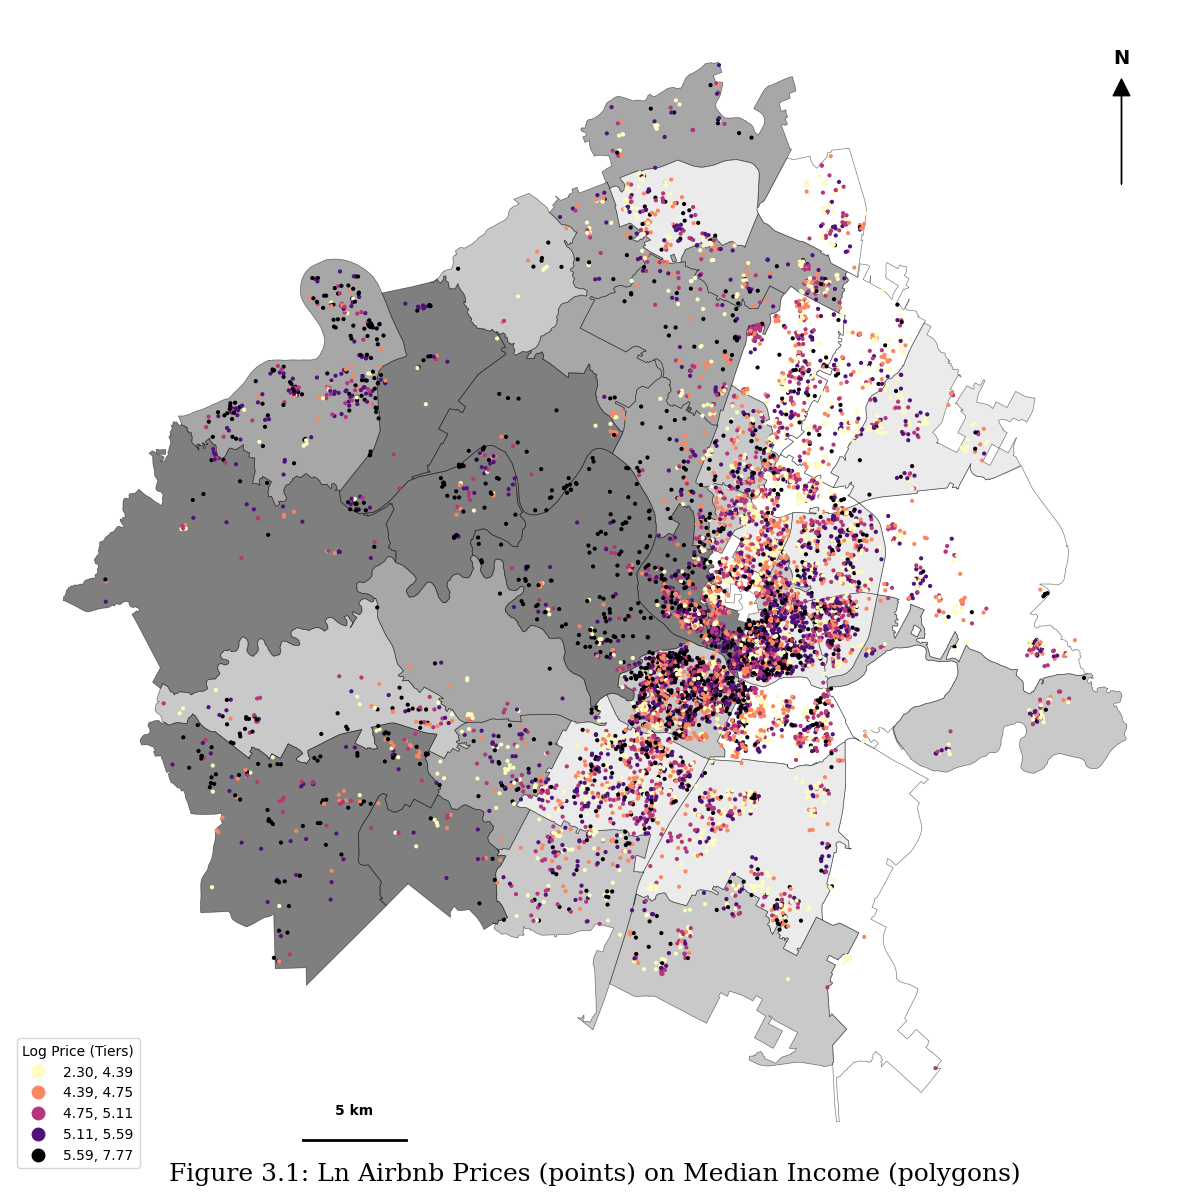

In [22]:
# Figur 3: Overlaying Points on Polygons
fig3, ax = plt.subplots(figsize=(12, 12))

# Polygons as Median Household Income
# Quantiles was used to show the top/bottom 20% of wealth clearly
final_gdf.plot(column='median_income', scheme='Quantiles', k=5, cmap='Greys', 
               alpha=0.5, edgecolor='black', linewidth=0.5, ax=ax, 
               legend=True, legend_kwds={'loc': 'upper left', 'title': 'Median Income ($)'})

# Points as Airbnb Listings (Log Price)
# Quantiles was used to get more information of skewed distributions
airbnb_gdf.plot(column='log_price', scheme='Quantiles',
                k=5, cmap='magma_r',     # Dark colors = High Price
                markersize=4, alpha=1.0, ax=ax, legend=True, 
                legend_kwds={'loc': 'lower left', 'title': 'Log Price (Tiers)'})

add_north_arrow(ax)
add_scale_bar(ax)
ax.set_axis_off()

fig3.text(0.5, 0.01, "Figure 3.1: Ln Airbnb Prices (points) on Median Income (polygons)", 
          ha='center', fontfamily='serif', fontsize=18)
plt.tight_layout()
plt.savefig('output/Figure 3a.jpeg', dpi=300)
plt.show()

Figure 3.1 overlaying log-transformed Airbnb prices onto income quantiles reveals two key patterns: higher prices cluster in affluent areas, reflecting amenity-based premiums, while the densest listings appear in mid-income, gentrifying tracts east of I-35-supporting Rent Gap Theory (Smith, 1979). These zones offer profit potential through the gap between current residential value and anticipated STR returns. Grey polygons show income quantiles (darker = richer), and point colours represent log-price tiers (~2.3-7.8), with brighter points marking the most expensive listings in the urban core and select west-side tracts.

**Compare Income vs. Airbnb Density**

In [19]:
# ==========================================
# ADDITIONAL ANALYSIS: BIVARIATE MAP (NaN-Safe Version)
# ==========================================

# Create a copy and remove rows with missing data just for this calculation
bi_gdf = final_gdf.dropna(subset=['median_income', 'listing_density']).copy()

# Create 3 categories (Tertiles)
# We use strings ('1','2','3') as labels directly to avoid integer conversion errors
bi_gdf['inc_bin'] = pd.qcut(bi_gdf['median_income'].rank(method='first'), 3, labels=['1', '2', '3'])
bi_gdf['den_bin'] = pd.qcut(bi_gdf['listing_density'].rank(method='first'), 3, labels=['1', '2', '3'])

# Combine into a single score (e.g., '11', '12'...)
bi_gdf['bi_class'] = bi_gdf['inc_bin'].astype(str) + bi_gdf['den_bin'].astype(str)

# Define the Bivariate Color Scheme
bi_colors = {
    '11': '#e8e8e8', '12': '#b0d5df', '13': '#64acbe', # Low Income
    '21': '#e4acac', '22': '#ad9ea5', '23': '#627f8c', # Med Income
    '31': '#c85a5a', '32': '#985356', '33': '#574249'  # High Income
}

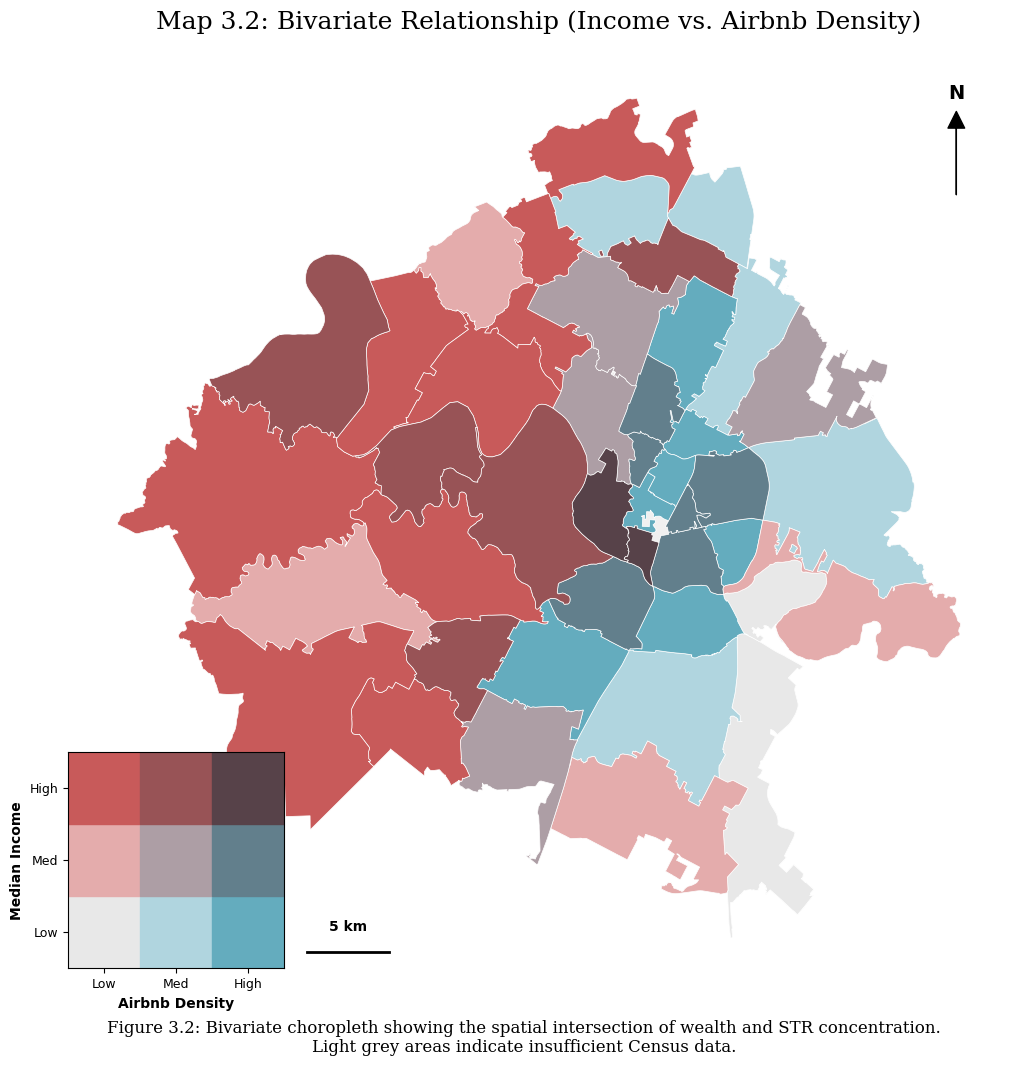

In [20]:
# Create the Map
fig_bi, ax = plt.subplots(figsize=(12, 12))

# First, plot the "Base" (everything) in light grey to show areas with NO data
final_gdf.plot(ax=ax, color='#f0f0f0', edgecolor='white', linewidth=0.5)

# Then, plot the Bivariate classes on top
for bi_val, color in bi_colors.items():
    bi_gdf[bi_gdf['bi_class'] == bi_val].plot(ax=ax, color=color, edgecolor='white', linewidth=0.5)

# Add map furniture
add_north_arrow(ax)
add_scale_bar(ax)
ax.set_axis_off()
ax.set_title("Map 3.2: Bivariate Relationship (Income vs. Airbnb Density)", 
             fontsize=18, fontfamily='serif', pad=20)

# CREATE THE LEGEND (The 3x3 Grid)
ax_legend = fig_bi.add_axes([0.12, 0.12, 0.18, 0.18]) 
for i, inc in enumerate(['1', '2', '3'], 1):
    for j, den in enumerate(['1', '2', '3'], 1):
        ax_legend.add_patch(plt.Rectangle((j, i), 1, 1, color=bi_colors[f"{inc}{den}"]))

ax_legend.set_xlim(1, 4); ax_legend.set_ylim(1, 4)
ax_legend.set_xticks([1.5, 2.5, 3.5]); ax_legend.set_yticks([1.5, 2.5, 3.5])
ax_legend.set_xticklabels(['Low', 'Med', 'High'], fontsize=9)
ax_legend.set_yticklabels(['Low', 'Med', 'High'], fontsize=9)
ax_legend.set_xlabel('Airbnb Density', fontsize=10, fontweight='bold')
ax_legend.set_ylabel('Median Income', fontsize=10, fontweight='bold')

fig_bi.text(0.5, 0.05, "Figure 3.2: Bivariate choropleth showing the spatial intersection of wealth and STR concentration.\nLight grey areas indicate insufficient Census data.", 
             ha='center', fontsize=12, fontfamily='serif')

plt.savefig('output/Figure_Bivariate.jpeg', dpi=300, bbox_inches='tight')
plt.show()

The bivariate analysis (Figure 3.2) moves beyond simple overlays to show the structural relationship between neighborhood wealth and platform capture. By isolating the Low-Income/High-Density (Teal) tracts, we can geographically pinpoint the 'Frontier Zones' where Austin's housing affordability is most under pressure from the global tourism market. Conversely, the High-Income/Low-Density (Red) clusters in the West demonstrate how socio-economic status can act as a barrier to platform expansion, effectively 'filtering' the sharing economy into more vulnerable transitional neighborhoods.

**3.4 Spatial Autocorrelation (LISA)**

In [40]:
# LISA Cluster Map
# Prepare data and dropping missing income rows
stats_gdf = final_gdf.dropna(subset=['median_income']).reset_index(drop=True)

# Creating spatial weight matrix
w = Queen.from_dataframe(stats_gdf, use_index=True)
w.transform = 'r'

# Calculate lLocal Moran's I
moran_loc = Moran_Local(stats_gdf['median_income'], w)

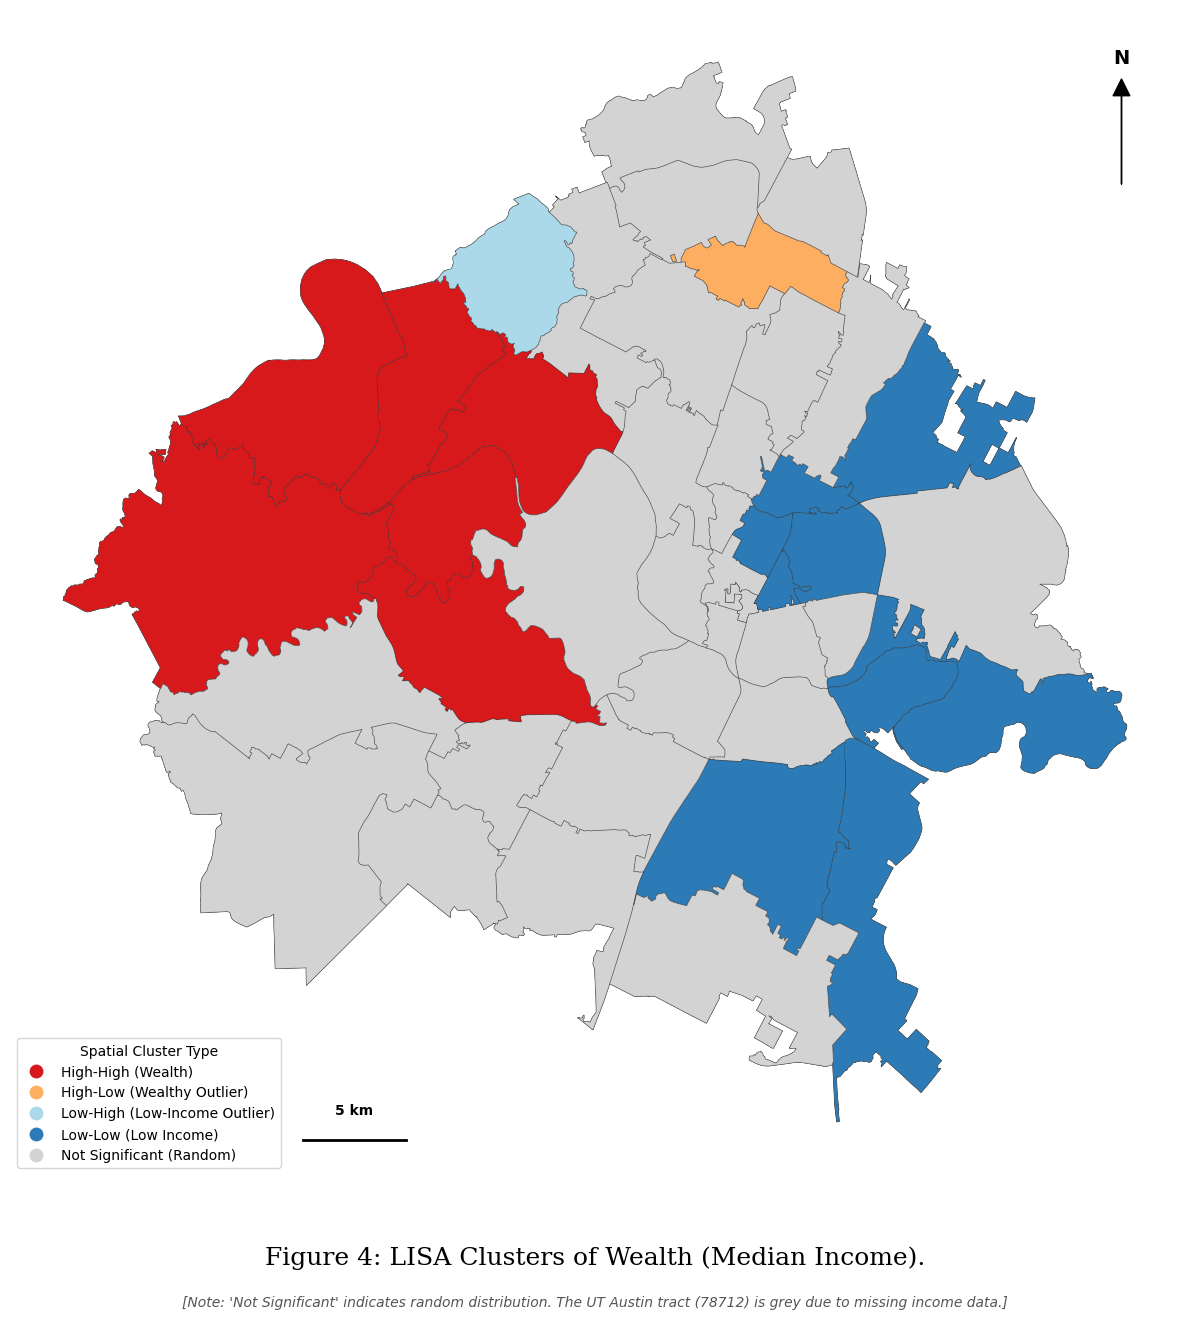

In [71]:
# Plotting
fig4, ax = plt.subplots(figsize=(12, 14))

#  Base Layer
# Filling the map with grey first, so if data is missing, it will shows grey color.
final_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)

# LISA Plot
# Plotting the LISA results. 'ns' (not significant)
lisa_cluster(moran_loc, stats_gdf, p=0.05, ax=ax,
             legend_kwds={'loc': 'lower left', 'title': 'Spatial Cluster Type'})

leg = ax.get_legend()
new_labels = {
    'HH': 'High-High (Wealth)',
    'LL': 'Low-Low (Low Income)',
    'HL': 'High-Low (Wealthy Outlier)',
    'LH': 'Low-High (Low-Income Outlier)',
    'ns': 'Not Significant (Random)'
}

for text in leg.get_texts():
    label = text.get_text()
    if label in new_labels:
        text.set_text(new_labels[label])

# Add Borders & Extras
stats_gdf.boundary.plot(ax=ax, linewidth=0.5, edgecolor='black', alpha=0.3)
add_north_arrow(ax)
add_scale_bar(ax)
ax.set_axis_off()

# Titles and Footnotes
fig4.text(0.5, 0.05, 
          "Figure 4: LISA Clusters of Wealth (Median Income).",
          ha='center', fontsize=18, fontfamily='serif')

fig4.text(0.5, 0.02, 
          "[Note: 'Not Significant' indicates random distribution. The UT Austin tract (78712) is grey due to missing income data.]", 
          ha='center', fontsize=10, style='italic', color='#555555')

plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.savefig('output/Figure 4.jpeg', dpi=300)
plt.show()

Local Indicators of Spatial Association (LISA) analysis (Figure 4) (Rey, Arribas-Bel & Wolf, 2020) was employed to identify statistically significant clusters of value, revealing intense spatial polarization in Austin’s income landscape. Conceptually, this method decomposes global autocorrelation to identify specific clusters where values are significantly correlated with their neighbors. The results reveal intense spatial polarization: High-High (HH) clusters (Red)-wealthy tracts surrounded by similarly affluent neighbors-are heavily concentrated in West Austin. In sharp contrast, Low-Low (LL) clusters (Blue) dominate the East and Southeast, statistically validating the "Eastern Crescent" of structural disadvantage rooted in the city's racialized planning history (Busch, 2017).

The scarcity of outliers suggests rigid socio-economic boundaries. Consequently, Airbnb expansion into LL tracts represents a distinct gentrifying pressure; introducing STR capital into these vulnerable areas risks displacing residents lacking the economic resilience of western enclaves (Wachsmuth & Weisler, 2018). The UT Austin was excluded due to negligible income data.

**3.5. Geodemographic Classification**

To identify neighbourhood typologies, a K-Means (k=4) clustering was undertaken using Z-scores of Listing Density, Average Price, Median Income, and Median Age.

In [51]:
# Impute missing data
fill_values = {
    'median_income': final_gdf['median_income'].median(),
    'median_age': final_gdf['median_age'].median(),
    'avg_price': final_gdf['avg_price'].min(), 
    'listing_density': 0
}
final_gdf_filled = final_gdf.fillna(value=fill_values).copy()

# Standardizing
cluster_vars = ['listing_density', 'avg_price', 'median_income', 'median_age']
scaler = StandardScaler()
data_scaled = scaler.fit_transform(final_gdf_filled[cluster_vars])

# K-Means
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
final_gdf_filled['cluster'] = kmeans.fit_predict(data_scaled)  

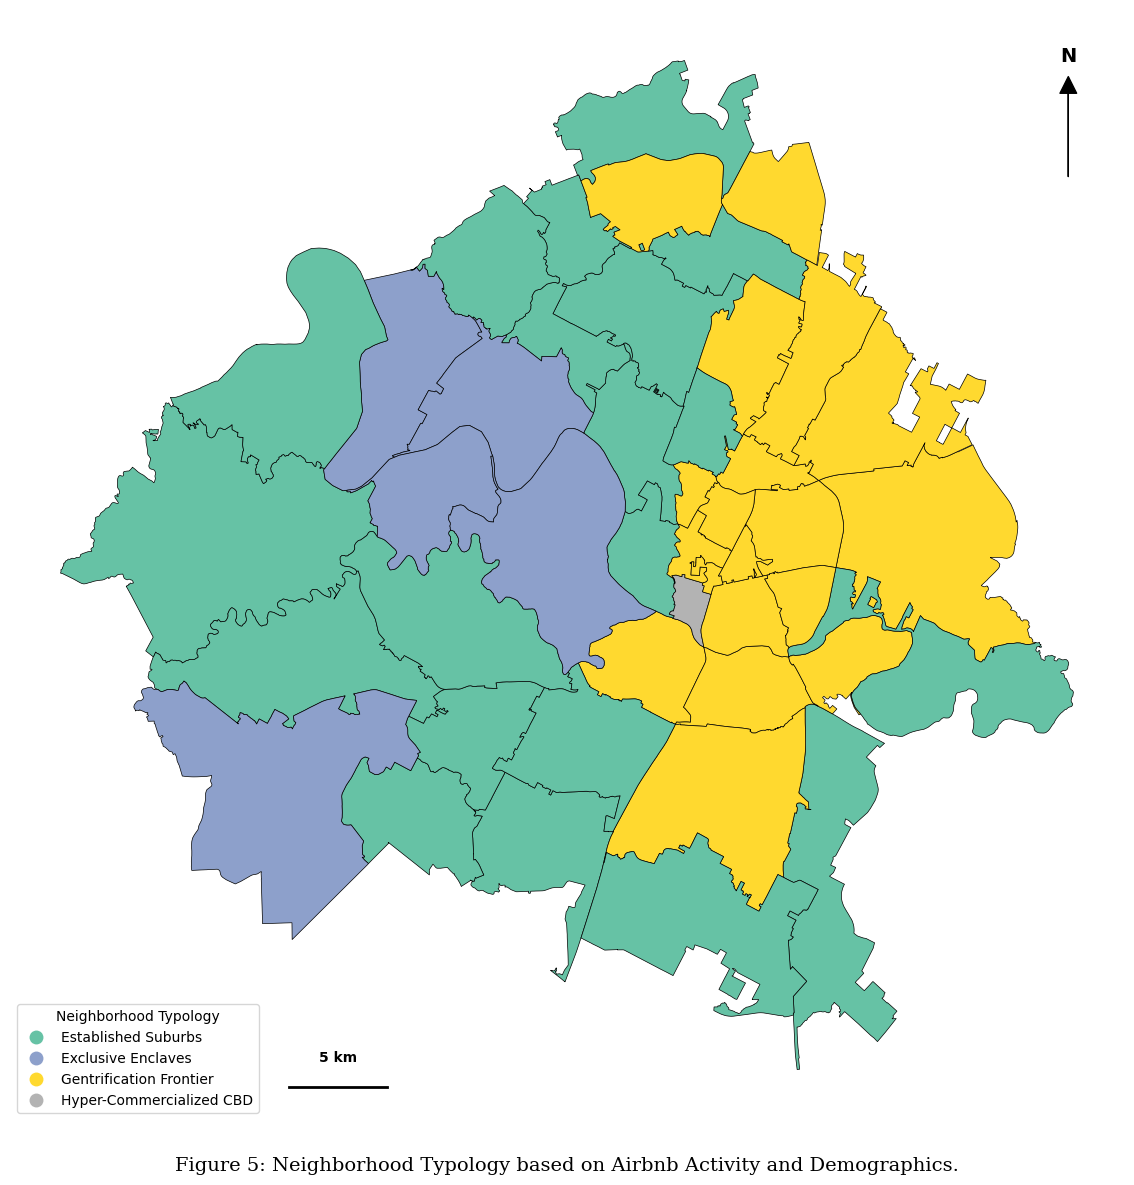

In [66]:
# Plotting cluster
# 0 = West/Green (Wealthy)
# 1 = East/Purple (Frontier)
# 2 = Background/Yellow (Suburban)
# 3 = Center/Grey (CBD)

cluster_labels = {
    0: 'Exclusive Enclaves',
    1: 'Gentrification Frontier',
    2: 'Established Suburbs',
    3: 'Hyper-Commercialized CBD'
}

# Creating a column for the names
final_gdf_filled['cluster_name'] = final_gdf_filled['cluster'].map(cluster_labels)

fig5, ax = plt.subplots(figsize=(12, 12))

final_gdf_filled.plot(column='cluster_name', # Plot the NAME, not the number
                      categorical=True, 
                      cmap='Set2', 
                      legend=True, 
                      edgecolor='black', 
                      linewidth=0.5, 
                      ax=ax,
                      legend_kwds={'title': 'Neighborhood Typology', 
                                   'loc': 'lower left'})

add_north_arrow(ax)
add_scale_bar(ax)
ax.set_axis_off()

fig5.text(0.5, 0.02, "Figure 5: Neighborhood Typology based on Airbnb Activity and Demographics.", 
              ha='center', fontsize=14, fontfamily='serif')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('output/Figure 5.jpeg', dpi=300)
plt.show()

In [68]:
# Table 1
print("\n" + "="*80)
print("Table 1: Characteristics of Each Cluster")
print("="*80)

# Calculating the average of each variable for each cluster
summary = final_gdf_filled.groupby('cluster')[cluster_vars].mean()
summary['Count'] = final_gdf_filled['cluster'].value_counts() # Add count of neighborhoods

# Renaming columns
summary = summary.rename(columns={
    'listing_density': 'Airbnb Density',
    'avg_price': 'Avg Price ($)',
    'median_income': 'Income ($)',
    'median_age': 'Age (Years)'
})

# Income & Age: Rounded to whole number and converted to Integer
summary['Income ($)'] = summary['Income ($)'].round(0).astype(int)
summary['Age (Years)'] = summary['Age (Years)'].round(0).astype(int)

# Density & Price: Round to 1 decimal point
summary['Airbnb Density'] = summary['Airbnb Density'].round(1)
summary['Avg Price ($)'] = summary['Avg Price ($)'].round(1)

print(summary)
print("="*80)
print("Source: Inside Airbnb (2025), US Census Bureau (ACS 2022).")


Table 1: Characteristics of Each Cluster
         Airbnb Density  Avg Price ($)  Income ($)  Age (Years)  Count
cluster                                                               
0                   1.8          483.6      169774           41      5
1                  27.0          153.9       74921           31     19
2                   5.4          203.0      111801           40     19
3                 196.4          235.1      148049           42      1
Source: Inside Airbnb (2025), US Census Bureau (ACS 2022).


Figure 5 establishes a neighborhood typology based on Airbnb activity and demographics:

* **Cluster 3:** Hyper-Commercialized CBD (Grey) (Figure 5). Represented by a single outlier tract (n=1), this cluster defines the "tourism core" with extreme listing density (196.4 listings/km²). Contrary to student areas, the demographic is older (42 years) and affluent (~148k dollars) (Table 1), suggesting a landscape dominated by luxury high-rises and professionalized STRs rather than youth housing.
* **Cluster 2:** Established Suburbs (Yellow) (Figure 5). The largest spatial group, characterized by stable middle-class incomes (~111k dollars) and low STR activity, serving as the residential baseline of the city..
* **Cluster 1:** The Gentrification Frontier (Purple) (Figure 5). Located predominantly east of I-35, this cluster combines moderate-to-high Airbnb density (27.0) with the city's lowest incomes (~75k dollars) and youngest population (31 years). This is the critical "risk zone" where STR pressure intersects directly with vulnerable renters and millennials.
* **Cluster 0:** Exclusive Enclaves (Green) (Figure 5). Concentrated in the West, these tracts exhibit the highest incomes (~170k dollars) and nightly prices (483.6) but the lowest listing density (1.8) (Table 1). This confirms that wealth acts as a "shield," insulating these neighborhoods from STR penetration through HOAs and restrictive zoning.

Policy intervention is most urgent in Cluster 1, where the rent gap is widest and displacement risk is highest.

## 4. Application

Policy should prioritize Cluster 1, where displacement risks are acute. Capping non-owner-occupied STR licenses here could curb speculation without penalizing home-sharing. Complementary measures-monitoring conversions and incentivizing long-term housing-are essential to preserve affordability. Adopting a cluster-specific approach ensures regulations respond to Austin’s spatial inequalities rather than applying "one-size-fits-all" solutions.

## 5. Conclusion

This analysis demonstrates that Airbnb’s expansion in Austin is deeply structured by existing socio-economic fissures. Integrating platform data with Census demographics reveals that STRs cluster in transitional neighborhoods-specifically the "Frontier Zone"-where gentrification pressures are strongest. Conversely, wealthy enclaves remain insulated. Through spatial statistics and clustering, this essay highlights how computational geography exposes structural inequalities that aggregate metrics often obscure.

## References
* Brewer, C.A. (2016). Designing Better Maps: A Guide for GIS Users. 2nd edn. Redlands: Esri Press.
* Busch, A. (2017). City in a Garden: Environmental Transformations and Racial Justice in Twentieth-Century Austin, Texas. Chapel Hill: UNC Press.
* Goodchild, M.F. (2007). 'Citizens as sensors: the world of volunteered geography', GeoJournal, 69(4), pp. 211-221.
* Jenks, G.F. (1967). 'The Data Model Concept in Statistical Mapping', International Yearbook of Cartography, 7, pp. 186-190.
* Office for National Statistics (2021). Census 2021 specifications: Age and Sex variables. London: ONS.
* Rey, S.J., Arribas-Bel, D. and Wolf, L.J. (2020). Geographic Data Science with Python. Bristol: Bristol University Press.
* Smith, N. (1979). 'Toward a Theory of Gentrification', Journal of the American Planning Association, 45(4), pp. 538-548.
* US Census Bureau (2022). American Community Survey 2018-2022 5-Year Estimates. Available at: https://data.census.gov.
* Wachsmuth, D. and Weisler, A. (2018). 'Airbnb and the rent gap: Gentrification through the sharing economy', Environment and Planning A, 50(6), pp. 1147-1170.